In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor,TFAutoModel,TFViTModel,ViTImageProcessor
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight

c:\Users\ASUS\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataset path and image size
dataset_dir = r'C:\Users\ASUS\Desktop\Resources\Resources\Waste\train'
categories = ['Recyclable', 'food', 'hazardous']
img_width, img_height = 224, 224

In [3]:
# Function to filter invalid images
def filter_invalid_images(directory):
    for category in categories:
        folder_path = os.path.join(directory, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify the image
            except (IOError, SyntaxError):
                print(f"Invalid image removed: {file_path}")
                os.remove(file_path)

# Run the filter
filter_invalid_images(dataset_dir)

In [4]:
# Data augmentation and train-validation split
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Train and validation generators
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=16,  # Increased batch size for faster convergence
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=16,  # Increased batch size for validation as well
    class_mode='categorical',
    subset='validation'
)

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
print(train_generator.image_shape)  # Should output (224, 224, 3)


# Compute class weights to address imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

Found 11242 images belonging to 3 classes.
Found 2808 images belonging to 3 classes.
(224, 224, 3)
{0: 0.4614942528735632, 1: 2.430177258971033, 2: 2.3717299578059072}


In [16]:
# Function to display images
def plot_images(images_arr, labels_arr, class_labels):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(class_labels[np.argmax(lbl)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display 5 images from the training dataset
train_images, train_labels = next(datagen)  # Get a batch of images
class_labels = list(datagen.class_indices.keys())  # Get class names
plot_images(train_images[:5], train_labels[:5], class_labels)

# Display 5 images from the validation dataset
val_images, val_labels = next(datagen)  # Get a batch of images
plot_images(val_images[:5], val_labels[:5], class_labels)

TypeError: 'ImageDataGenerator' object is not an iterator

In [ ]:
# CNN Model (using the same structure as before)
def build_cnn_model():
    model = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_width, img_height, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),  # You can also try a smaller learning rate (e.g., 0.0005)
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

    return model


In [27]:
# Build the Autoencoder
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(256, activation='relu')(input_layer)
    bottleneck = Dense(128, activation='relu')(encoder)
    decoder = Dense(256, activation='relu')(bottleneck)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

# Extract features using the trained CNN
def extract_features(generator, cnn_model):
    features, labels = [], []
    for images, label_batch in generator:
        features_batch = cnn_model.predict(images, verbose=0)
        features.append(features_batch)
        labels.append(label_batch)
        if len(features) * generator.batch_size >= generator.samples:
            break  # Stop after processing all samples
    return np.vstack(features), np.vstack(labels)

# Prepare data for autoencoder
def prepare_autoencoder_data(generator, cnn_model):
    features, _ = extract_features(generator, cnn_model)
    return features

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

with tf.device('/device:GPU:0'):
    cnn_model = build_cnn_model()

tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1


In [34]:
# Train Autoencoder
def train_autoencoder(autoencoder, train_features, validation_features, epochs=50):
    history = autoencoder.fit(
        train_features, train_features,
        validation_data=(validation_features, validation_features),
        epochs=epochs,
        batch_size=32,
        callbacks=[lr_scheduler, early_stopping]
    )
    return history

# Detect anomalies
def detect_anomalies(autoencoder, test_features, threshold):
    reconstructed = autoencoder.predict(test_features)
    reconstruction_errors = mean_squared_error(test_features, reconstructed, multioutput='raw_values')
    anomalies = reconstruction_errors > threshold
    return anomalies, reconstruction_errors

In [43]:
# Step 1: Train CNN model (already in your code)
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)
cnn_model.save('cnn_model.h5')

# Step 2: Extract features
train_features = prepare_autoencoder_data(train_generator, cnn_model)
validation_features = prepare_autoencoder_data(validation_generator, cnn_model)

# Step 3: Build and train the autoencoder
autoencoder = build_autoencoder(train_features.shape[1])
autoencoder_history = train_autoencoder(autoencoder, train_features, validation_features)

# Step 4: Detect anomalies on new data
test_generator = datagen.flow_from_directory(
    dataset_dir,  # Path to test data
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_features, test_labels = extract_features(test_generator, cnn_model)
threshold = np.mean(autoencoder_history.history['val_loss']) + 2 * np.std(autoencoder_history.history['val_loss'])
anomalies, reconstruction_errors = detect_anomalies(autoencoder, test_features, threshold)

# Step 5: Analyze anomalies
print(f"Anomalies Detected: {anomalies.sum()} / {len(test_features)}")
for i, is_anomaly in enumerate(anomalies):
    if is_anomaly:
        print(f"Sample {i} is a new type of waste.")

KeyboardInterrupt: 

In [46]:
# Evaluate CNN
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(validation_generator)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.2f}")

176/176 [==============================] - 27s 151ms/step - loss: 0.6518 - accuracy: 0.8152
CNN Test Accuracy: 0.82


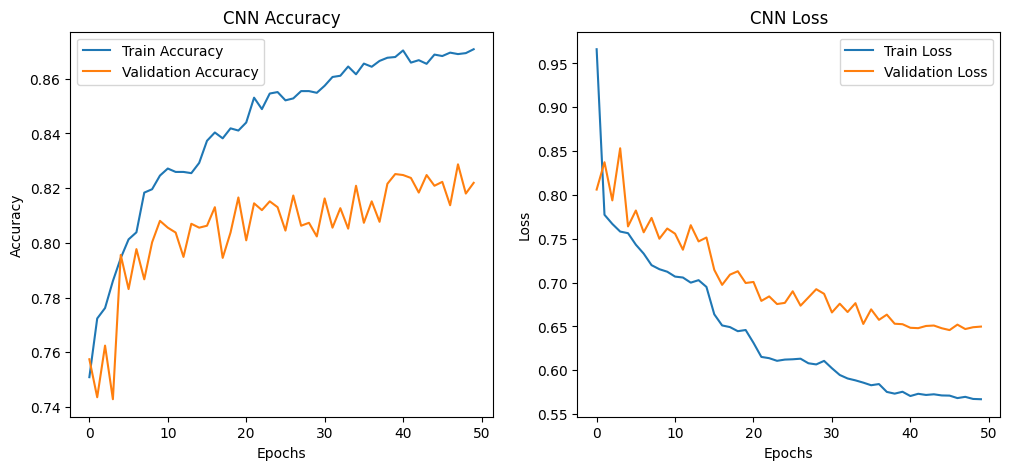

In [47]:
# Plot accuracy and loss for CNN
def plot_metrics(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_metrics(cnn_history, "CNN")


176/176 [==============================] - 26s 149ms/step


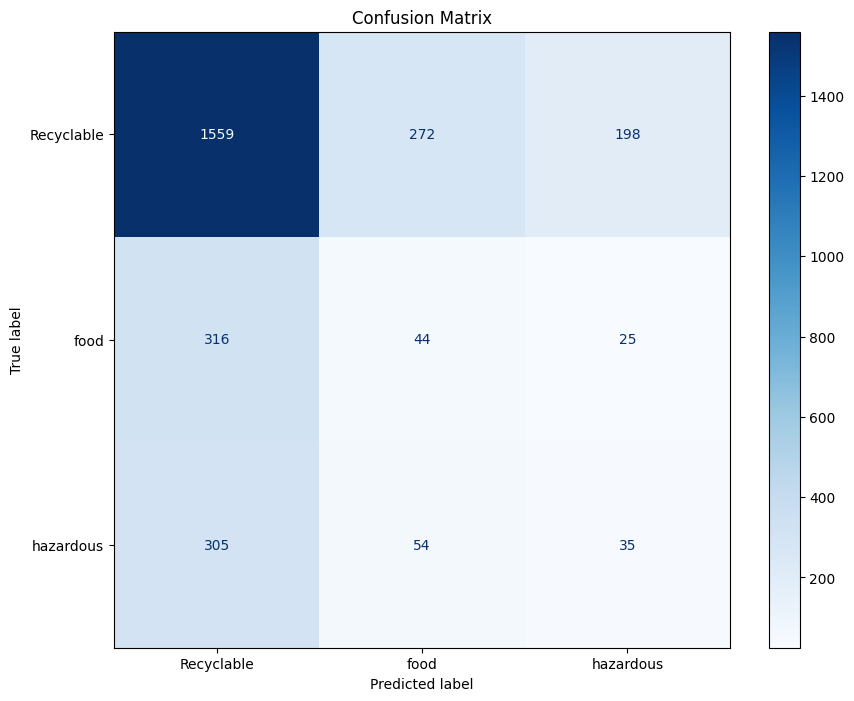

In [45]:
# Get predictions and true labels
y_pred = cnn_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = validation_generator.classes  # True labels

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

In [44]:
# Confusion Matrix plotting
def plot_confusion_matrix(model, validation_generator):
    # Get the true labels and predictions
    val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
    Y_pred = model.predict(validation_generator, steps=val_steps, verbose=1)
    y_pred = np.argmax(Y_pred, axis=1)

    true_classes = validation_generator.classes[:len(y_pred)]  # Ensure true_classes and y_pred have the same length
    class_labels = list(validation_generator.class_indices.keys())

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Print detailed classification report
    print('Classification Report')
    print(classification_report(true_classes, y_pred, target_names=class_labels))

# Plot confusion matrix and classification report
plot_confusion_matrix(model_12, validation_generator)   

NameError: name 'model_12' is not defined

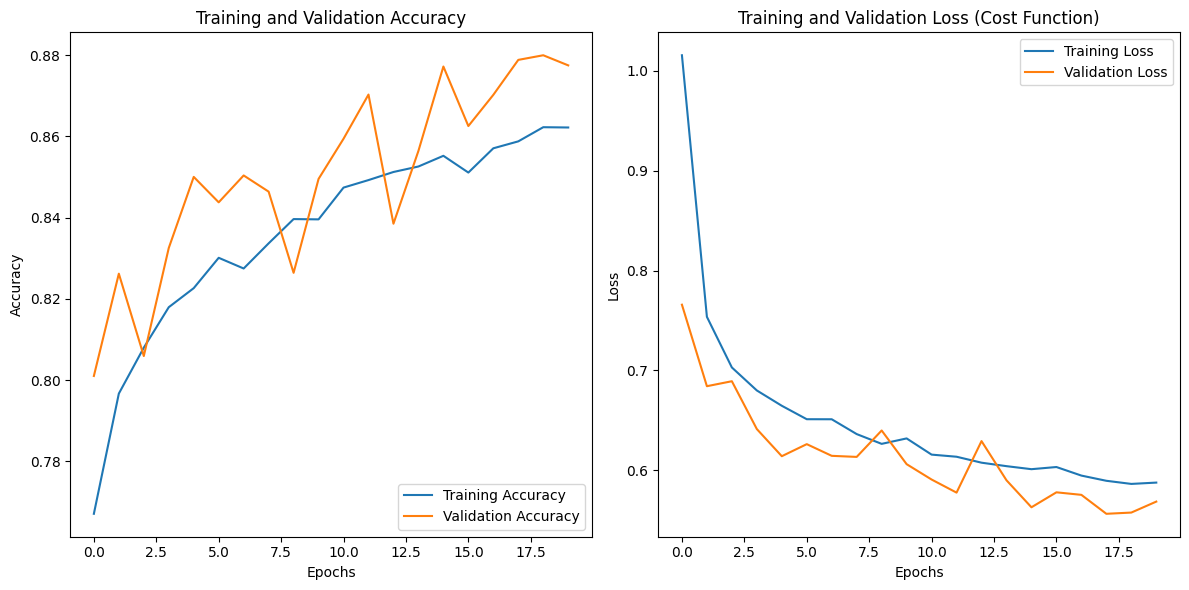

In [33]:
# Plot training & validation accuracy and loss values
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss (cost function)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss (Cost Function)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
plot_training_history(history)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image  # Correct import for TensorFlow/Keras
import os
import cvzone
import serial
import time
import tensorflow as tf

# Constants for image dimensions and paths
img_width, img_height = 224, 224  # Model input size
background_path = r'Resources\background.png'
arrow_path = r'Resources\arrow.png'
pathFolderBins = "Resources/Bins"
img_path = r'C:\Users\ASUS\Desktop\Resources\Resources\Waste\train\Recyclable\alum (193).jpg'
class_labels = ['Recyclable', 'Hazardous', 'Food Waste']

# Load the CNN model
model = tf.keras.models.load_model('cnn_model.h5')

# Load and preprocess the image for prediction
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    prediction = model.predict(img_array)
    return prediction

# Load bin images
imgBinsList = [cv2.imread(os.path.join(pathFolderBins, path), cv2.IMREAD_UNCHANGED) for path in os.listdir(pathFolderBins)]

# Predict the image category
prediction = predict_image(img_path, model)
predicted_class = np.argmax(prediction)
predicted_label = class_labels[predicted_class]
print(f'Predicted class: {predicted_label}')

# Load the background and arrow images
imgBackground = cv2.imread(background_path)
imgArrow = cv2.imread(arrow_path, cv2.IMREAD_UNCHANGED)

if imgBackground is None or imgArrow is None:
    print("Error: Image(s) not loaded.")
    exit()

# Resize waste image and overlay on background
img = cv2.imread(img_path)
if img is None:
    print("Error: Waste image not loaded.")
    exit()
imgResize = cv2.resize(img, (454, 340))
imgBackground[148:148 + 340, 159:159 + 454] = imgResize
imgBackground = cvzone.overlayPNG(imgBackground, imgArrow, (978, 320))

# Overlay selected bin image
bin_image = imgBinsList[predicted_class]
imgBackground = cvzone.overlayPNG(imgBackground, bin_image, (895, 374))

# Setup Arduino serial communication
try:
    arduino = serial.Serial(port='COM3', baudrate=9600, timeout=1)
    time.sleep(2)  # Wait for connection
except serial.SerialException as e:
    print(f"Error connecting to Arduino: {e}")
    exit()

# Send prediction to Arduino
#arduino.write(b'R' if predicted_label.lower() == 'recyclable' else b'H' if predicted_label.lower() == 'hazardous' else b'F')

#arduino.close()

# Display the final result
cv2.imshow("Waste Classifier Output", imgBackground)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 4s 4s/step
Predicted class: Recyclable
Error connecting to Arduino: could not open port 'COM3': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)


: 